In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [2]:
df = pd.read_csv("cleaned_plyear_data.csv")

In [3]:
df

,Team,Position,Height,Age,Appearances,Goals,Assists,Yellow_Cards,Second_Yellow_Cards,Red_Cards,Goals_Conceded,Clean_Sheets,Minutes_Played,Days_Injured,Games_Injured,Award,Current_Value,Highest_Value,Position_Encoded,Winger
0,Manchester United,Goalkeeper,196.000000,30.0,15,0.000000,0.000000,0.069018,0.0,0.000000,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0
1,Manchester United,Goalkeeper,188.000000,37.0,4,0.000000,0.000000,0.000000,0.0,0.000000,0.616438,0.924658,292,697,84,4,600000,6000000,1,0
2,Manchester United,Defender Centre-Back,185.000000,31.0,8,0.000000,0.000000,0.216346,0.0,0.000000,0.000000,0.000000,416,932,169,7,2000000,20000000,2,0
3,Manchester United,Defender Centre-Back,186.000000,21.0,34,0.000000,0.000000,0.130529,0.0,0.000000,0.000000,0.000000,2758,47,13,0,2000000,2000000,2,0
4,Manchester United,Defender Left-Back,169.000000,23.0,89,0.012619,0.063096,0.227145,0.0,0.000000,0.000000,0.000000,7132,182,15,3,22000000,22000000,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10298,Western Sydney Wanderers,Attack-RightWinger,181.240353,20.0,16,0.175953,0.087977,0.263930,0.0,0.000000,0.000000,0.000000,1023,0,0,0,75000,75000,4,1
10299,Western Sydney Wanderers,Attack Centre-Forward,190.000000,24.0,26,0.372671,0.186335,0.186335,0.0,0.000000,0.000000,0.000000,1449,102,18,0,300000,300000,4,0
10300,Western Sydney Wanderers,Attack Centre-Forward,181.240353,19.0,20,0.375000,0.000000,0.187500,0.0,0.000000,0.000000,0.000000,960,0,0,0,50000,50000,4,0
10301,Western Sydney Wanderers,Attack Centre-Forward,181.240353,20.0,17,0.312139,0.104046,0.000000,0.0,0.104046,0.000000,0.000000,865,0,0,0,50000,50000,4,0


In [4]:
categorical_features = df.select_dtypes(include=['object']).columns
categorical_features

Index(['Team', 'Position'], dtype='object')

In [5]:
df = pd.get_dummies(df, columns=categorical_features)

In [6]:
p25 = df['Current_Value'].quantile(0.25)
p50 = df['Current_Value'].quantile(0.50)
p90 = df['Current_Value'].quantile(0.90)

# Function to categorize prices
def categorize_Current_Value(Current_Value):
    if Current_Value < p25:
        return 'bad playere'
    elif Current_Value < p50:
        return 'good player'
    elif Current_Value < p90:
        return 'Excellent player'
    else:
        return 'legend'

# Apply the function to create a new column
df['categorize_Current_Value'] = df['Current_Value'].apply(categorize_Current_Value)

df.drop('Current_Value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['categorize_Current_Value'].value_counts())

categorize_Current_Value
Excellent player    4257
bad playere         2530
good player         2372
legend              1144
Name: count, dtype: int64


In [7]:
encoder = LabelEncoder()
df['categorize_Current_Value'] = encoder.fit_transform(df['categorize_Current_Value'])  

In [8]:
correlation = df.corr(numeric_only=True)
print(correlation['categorize_Current_Value'].sort_values(ascending=False))

categorize_Current_Value        1.000000
Highest_Value                   0.286380
Team_Southampton FC             0.075357
Team_AS Monaco                  0.071601
Appearances                     0.067741
                                  ...   
Team_AJ Auxerre                -0.035094
Team_Real Valladolid CF        -0.036589
Team_Fortaleza Esporte Clube   -0.041784
Team_Elche CF                  -0.044584
Age                            -0.048522
Name: categorize_Current_Value, Length: 405, dtype: float64


In [9]:
threshold = 0.07  
selected_features = correlation[abs(correlation['categorize_Current_Value']) > \
threshold]['categorize_Current_Value'].index
selected_features

Index(['Highest_Value', 'Team_AS Monaco', 'Team_Southampton FC',
       'categorize_Current_Value'],
      dtype='object')

In [10]:
selected_features = ['Highest_Value', 'Team_AS Monaco', 'Team_Southampton FC',
       'categorize_Current_Value']

In [11]:
X = df.drop(['categorize_Current_Value'], axis=1)
y = df['categorize_Current_Value']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
dt_classifier = DecisionTreeClassifier()
rf_classifier = RandomForestClassifier()

In [28]:
param_grid = {
    'max_depth': [4, 5, 6, 7, 10, 15],   
    'n_estimators':[35, 40, 50, 60]
}
grid_search = GridSearchCV(estimator=rf_classifier,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro', 
                           verbose=1)

In [30]:
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier()

In [34]:
rf_classifier.fit(X_train, y_train)

RandomForestClassifier()

In [36]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7, 10, 15],
                         'n_estimators': [35, 40, 50, 60]},
             scoring='f1_macro', verbose=1)

In [37]:
grid_search.best_params_

{'max_depth': 15, 'n_estimators': 40}

In [40]:
best_model = grid_search.best_estimator_


In [44]:
y_pred_dt = dt_classifier.predict(X_test)
y_pred_rf = rf_classifier.predict(X_test)
y_pred_rf_g = best_model.predict(X_test)

In [46]:
base_model = round(df['categorize_Current_Value'].value_counts()[1]/df.shape[0]*100, 2)
base_model

24.56

In [48]:
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Decision Tree accuracy", accuracy_dt)

Decision Tree accuracy 0.7884522076661815


In [50]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest accuracy", accuracy_rf)

Random Forest accuracy 0.7996118389131489


In [52]:
y_pred_train_dt = dt_classifier.predict(X_train)
accuracy_train_dt = accuracy_score(y_train, y_pred_train_dt)
print("Decision Tree train accuracy",accuracy_train_dt)

Decision Tree train accuracy 1.0


In [54]:
y_pred_train_rf = rf_classifier.predict(X_train)
accuracy_train_rf = accuracy_score(y_train, y_pred_train_rf)
print("Random Forest Train accuracy",accuracy_train_rf)

Random Forest Train accuracy 1.0


In [56]:
accuracy = accuracy_score(y_test, y_pred_rf_g)
accuracy

0.7612809315866085

In [58]:
y_pred_train_rf_g = best_model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_train_rf_g)
accuracy

0.8216452317398689

In [60]:
conf_matrix = confusion_matrix(y_test, y_pred_rf_g)
conf_matrix

array([[830,   7,   6,   7],
       [ 55, 404,  45,   0],
       [192,  48, 243,   0],
       [131,   1,   0,  92]], dtype=int64)

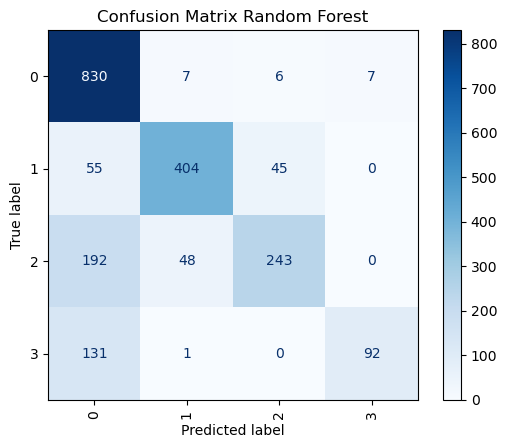

In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_g,
                                        display_labels=best_model.classes_,
                                        cmap="Blues",
                                        xticks_rotation='vertical')
plt.title('Confusion Matrix Random Forest' )
plt.show()

In [70]:
precision = precision_score(y_test, y_pred_rf_g, average='macro')
print(f"Random Forest Precision: {precision:.2f}")

Random Forest Precision: 0.83


In [72]:
recall = recall_score(y_test, y_pred_rf_g, average='macro')
print(f" Random Forest Recall: {recall:.2f}")

 Random Forest Recall: 0.67


In [74]:
f1 = f1_score(y_test, y_pred_rf_g, average='macro')
print(f"Random Forest F1 Score: {f1:.2f}")

Random Forest F1 Score: 0.71
